In [1]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats, io

BIDS_path= "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
faces = io.loadmat('..\\..\\icn_plots\\faces.mat')
Vertices = io.loadmat('..\\..\\icn_plots\\Vertices.mat')
grid = io.loadmat('..\\..\\icn_plots\\grid.mat')['grid']
stn_surf = io.loadmat('..\\..\\icn_plots\\STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

In [2]:
def get_coords_df_from_vhdr(vhdr_file, BIDS_path):
    """
    given a vhdr file path and the BIDS path
    :return a pandas dataframe of that session (important: not for the run; run channls might have only a s
    subset of all channels in the coordinate file)
    """
    subject = vhdr_file[vhdr_file.find('sub-')+4:vhdr_file.find('sub-')+7]

    if vhdr_file.find('right') !=-1:
        sess = 'right'
    else:
        sess = 'left'
    coord_path = os.path.join(BIDS_path, 'sub-'+ subject, 'ses-'+ sess, 'ieeg', 'sub-'+ subject+ '_electrodes.tsv')
    df = pd.read_csv(coord_path, sep="\t")
    return df

def get_all_vhdr_files(BIDS_path):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(".vhdr"):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_file

def get_coords(sub, sess_, str_loc="ECOG"):
    coord_path = os.path.join(BIDS_path, 'sub-'+ sub, 'ses-'+ sess_, 'ieeg', 'sub-'+ sub+ '_electrodes.tsv')
    df = pd.read_csv(coord_path, sep="\t")
    return np.array(df[df["name"].str.contains(str_loc) & 
                       df["name"].str.contains(sess_.upper())][["x", "y", "z"]])

def get_c_coord(sub, loc, lat, PATH_):
    
    res_files = os.listdir(PATH_)
    files = [f for f in res_files if (sub in f) and (loc in f)]

    res = np.load(os.path.join(PATH_, files[0]), allow_pickle=True).tolist()
    sess_ = files[0][files[0].find("ses-")+4:files[0].find(".npy")]
    if loc == "ECOG":
        coord_ = get_coords(sub, sess_, "ECOG")
        max_ = res["score_te"][lat]
        if sub == "006": coord_ = coord_[:max_.shape[0],:] 
    else: # STN
        max_ = res["score_te"][lat]
        max_ = [max_[0], (max_[0]+max_[1])/2, (max_[1]+max_[2])/2, max_[2]]
        coord_ = get_coords(sub, sess_, "STN")
    if len(files) > 1:
        res = np.load(os.path.join(PATH_, files[1]), allow_pickle=True).tolist()
        sess_ = files[1][files[1].find("ses-")+4:files[1].find(".npy")]
        if loc == "ECOG":
            coord_new_sess = get_coords(sub, sess_, "ECOG")
            max_ = np.concatenate((max_, res["score_te"][lat]), axis=0)
            if sub == "006": coord_new_sess = coord_new_sess[:res["score_te"][lat].shape[0],:] 
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
        else: # STN 
            max_one = res["score_te"][lat]
            max_one = [max_one[0], (max_one[0]+max_one[1])/2, (max_one[1]+max_one[2])/2, max_one[2]]
            max_ = np.concatenate((max_, max_one), axis=0)
            coord_ = np.concatenate((coord_, get_coords(sub, sess_, "STN")), axis=0)
    return max_, coord_

def get_c_coord_SPOC(sub, loc, lat, PATH_):
    """
    Here the mean of each test fold performance is taken and repeated for every channel 
    """
    
    res_files = os.listdir(PATH_)
    files = [f for f in res_files if (sub in f) and (loc in f) and ("tlag" in f)]

    res = np.load(os.path.join(PATH_, files[0]), allow_pickle=True).tolist()
    sess_ = files[0][files[0].find("ses-")+4:files[0].find(".npy")]
    if loc == "ECOG":
        coord_ = get_coords(sub, sess_, "ECOG")
        max_ = np.array([np.mean(res["score_te"][lat]) for i in range(coord_.shape[0])])
        #if sub == "006": coord_ = coord_[:max_.shape[0],:] 
    else: # STN
        coord_ = get_coords(sub, sess_, "STN")
        max_ = np.array([np.mean(res["score_te"][lat]) for i in range(coord_.shape[0])])
        
    if len(files) > 1:
        res = np.load(os.path.join(PATH_, files[1]), allow_pickle=True).tolist()
        sess_ = files[1][files[1].find("ses-")+4:files[1].find(".npy")]
        if loc == "ECOG":
            coord_new_sess = get_coords(sub, sess_, "ECOG")
            max_new_sess = np.array([np.mean(res["score_te"][lat]) for i in range(coord_new_sess.shape[0])])
            max_ = np.concatenate((max_, max_new_sess), axis=0)
            #if sub == "006": coord_new_sess = coord_new_sess[:28,:] 
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
        else: # STN 
            coord_new_sess = get_coords(sub, sess_, "STN")
            max_one = np.array([np.mean(res["score_te"][lat]) for i in range(coord_new_sess.shape[0])])
            max_ = np.concatenate((max_, max_one), axis=0)
            coord_ = np.concatenate((coord_, coord_new_sess), axis=0)
    return max_, coord_

def plot_all_in_one(unit=r"$R^2$", c_lim=0.7, SPOC=False, PATH_RES="C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\XGB_Out\\"):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    fig, axes = plt.subplots(2,2, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                             figsize=(14,9))#, dpi=300)
    for idx in range(2):
        axes[0, idx].scatter(x_ecog, y_ecog, c="gray", s=0.001)
        axes[1, idx].scatter(x_stn, y_stn, c="gray", s=0.001)
        
        lat = "CON" if idx == 0 else "IPS"
        for sub in subjects:
            c , coord = get_c_coord_SPOC(sub, "ECOG", lat, PATH_RES) if SPOC is True else \
                    get_c_coord(sub, "ECOG", lat, PATH_RES)
            pos_ecog = axes[0, idx].scatter(coord[:,0], \
                        coord[:,1], c=c, s=10, alpha=0.8, cmap='viridis')
            c , coord = get_c_coord_SPOC(sub, "STN", lat, PATH_RES) if SPOC is True else \
                    get_c_coord(sub, "STN", lat, PATH_RES)
            pos_stn = axes[1, idx].scatter(coord[:,0], \
                        coord[:,1], c=c, s=10, alpha=0.8, cmap='viridis')
            
            
            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); 
            pos_ecog.set_clim(0,c_lim); 
            cbar_ecog.set_label(unit, color="white")
            cbar_ecog.ax.tick_params(axis='y', color='white')
            cbar_ecog.ax.set_yticklabels(labels=np.round(cbar_ecog.get_ticks(),2),color='white')
            cbar_ecog.outline.set_edgecolor('white')
            if sub != "000": cbar_ecog.remove() 
            
            if idx == 0:
                axes[0, idx].set_title('\ncontralateral performance', color='white')
            else:
                axes[0, idx].set_title('\nipsilateral performance', color='white')
            
        
            cbar_stn = fig.colorbar(pos_stn, ax=axes[1, idx]); 
            pos_stn.set_clim(0,c_lim); cbar_stn.remove()
            cbar_stn.outline.set_edgecolor('white')
            cbar_stn.ax.set_yticklabels(labels=np.round(cbar_stn.get_ticks(),2),color='white')
            cbar_stn.set_label(unit, color="white")

            axes[0, idx].axes.set_aspect('equal', anchor='C')
            axes[0, idx].set_facecolor((0,0,0))
            axes[1, idx].axes.set_aspect('equal', anchor='C')
            axes[1, idx].set_facecolor((0,0,0))

### XGB Res

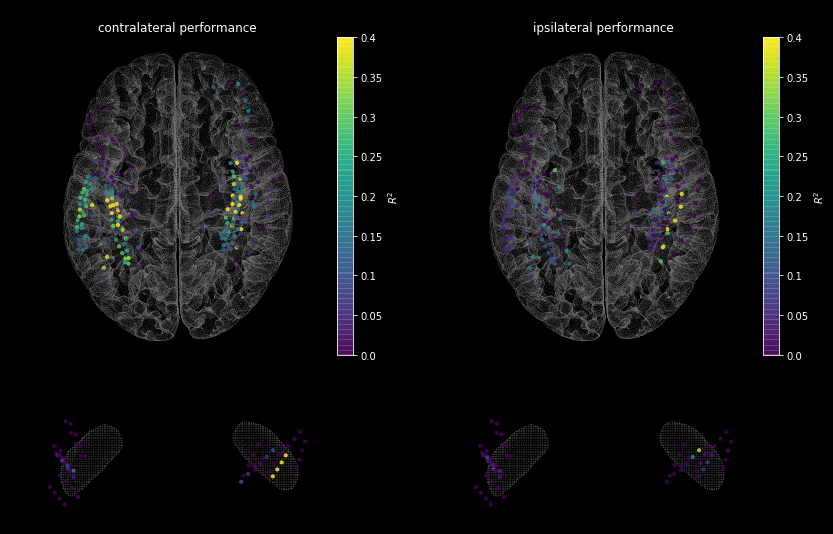

In [4]:
plot_all_in_one(c_lim=0.4, 
    PATH_RES="C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\XGB_Out\\")

### LM Res

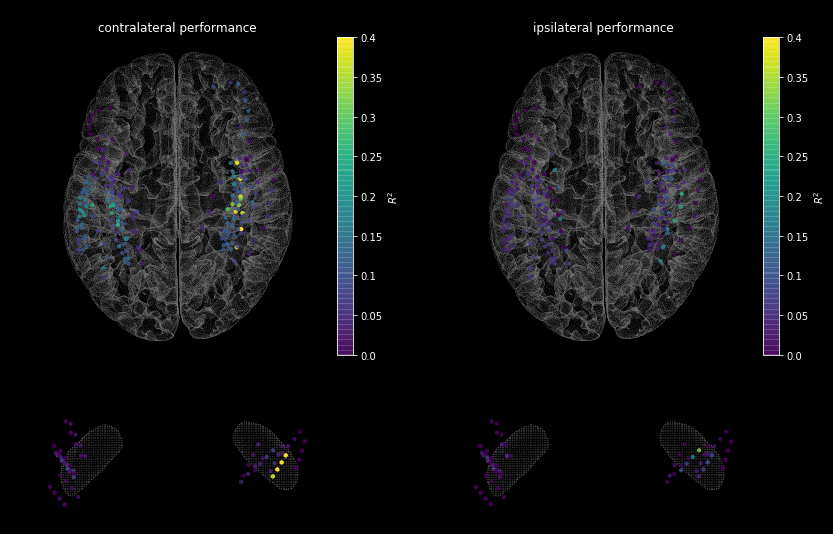

In [5]:
plot_all_in_one(c_lim=0.4, 
    PATH_RES="C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\LM_Out\\")

### SPOC res

In [6]:
PATH_="C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\SPOC_predictions\\"

In [ ]:
plot_all_in_one(c_lim=0.4, 
    PATH_RES=PATH_, SPOC=True)